# Image Segmentation

# Libraries used and their versions

The following libraries and their versions were installed and are required to run this notebook.
```
appnope==0.1.4
asttokens==2.4.1
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.8
decorator==5.1.1
executing==2.1.0
filelock==3.16.1
fonttools==4.55.0
fsspec==2024.10.0
ipykernel==6.29.5
ipython==8.29.0
jedi==0.19.2
Jinja2==3.1.4
joblib==1.4.2
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.7
MarkupSafe==3.0.2
matplotlib==3.9.2
matplotlib-inline==0.1.7
mpmath==1.3.0
nest-asyncio==1.6.0
networkx==3.4.2
numpy==2.1.3
opencv-python==4.10.0.84
packaging==24.2
parso==0.8.4
pexpect==4.9.0
pillow==11.0.0
platformdirs==4.3.6
prompt_toolkit==3.0.48
psutil==6.1.0
ptyprocess==0.7.0
pure_eval==0.2.3
Pygments==2.18.0
pyparsing==3.2.0
python-dateutil==2.9.0.post0
pyzmq==26.2.0
scikit-learn==1.5.2
scipy==1.14.1
setuptools==75.5.0
six==1.16.0
stack-data==0.6.3
sympy==1.13.1
threadpoolctl==3.5.0
torch==2.5.1
torcheval==0.0.7
torchvision==0.20.1
tqdm==4.67.0
traitlets==5.14.3
typing_extensions==4.12.2
wcwidth==0.2.13
```

# Imports

In [7]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
# from google.colab import drive
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib.pyplot import figure
import os
import torch
from torch import nn
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader, Dataset
import random
from torchvision.transforms.functional import InterpolationMode
import torcheval.metrics as metrics
import torch.nn.functional as F
import sklearn.mixture as mixture
import pickle

# Mount the drive location
# drive.mount('/content/drive')

# Modify this path when trying to run this code
path_to_project_root = "your_path"

# The paths to the data that is included with the assignment
train_set_images_path = f"{path_to_project_root}/Oxford/train/images"
train_set_masks_path = f"{path_to_project_root}/Oxford/train/masks"
test_set_images_path = f"{path_to_project_root}/Oxford/test/images"
generalization_image_path = f"{path_to_project_root}/generalization_img.jpg"

# 1- Data preparation

## 1.1- Data extraction and pre-processing

This first section is used to extract and pre-process the data the first time that the code is run. The preprocessing steps taken involve resizing the images (256x256 pixels by default) as well as normalizing the pixel values. Since the given dataset was already split into training and testing, we just split the training set into training and validation sets (70% training and 30% validation as instructed).

In [ ]:
# Helper function that sorts the files in numerical order
# Meaning 1, 2, 3,... instead of 1, 100, 1000...
def sort_files(files):
    return sorted(files, key=lambda x: int(x.split(".")[0]))

# Helper function to extract the data and resize it
def extract_data(image_path, mask_path=None, resize_dim=256):

    # To store the images and their labels
    images = []
    labels = []

    # Iterate through the images
    for filename in tqdm(sort_files(os.listdir(image_path))):

      # Remove the extension
      filename = filename.split(".")[0]

      # Read the image
      img = cv2.imread(os.path.join(image_path, f"{filename}.jpg")) # Read the image

      # If the image is not corrupted
      if img is not None:
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
          img = img / 255.0 # Normalize the image
          img = cv2.resize(img, (resize_dim, resize_dim)) # Resize the image
          images.append(img) # Add the image to the list
          if mask_path is not None:
            mask = cv2.imread(os.path.join(mask_path, f"{filename}.png"), cv2.IMREAD_GRAYSCALE) # Read the mask (Grayscale)
            mask = cv2.resize(mask, (resize_dim, resize_dim)) # Resize the mask
            labels.append(mask) # Add the mask to the list

      # If the image is corrupted
      else:

        # Print a message and create a black image
        print(f"Image {filename} not found; Replacing with a black image")
        img = np.zeros((resize_dim, resize_dim, 3)) # Create a black image
        images.append(img) # Add the image to the list

        # If the masks are also requested
        if mask_path is not None:
          mask = np.zeros((resize_dim, resize_dim))
          labels.append(mask) # Add the mask to the list

    # Return the resized images and their labels
    return np.array(images), np.array(labels)

# Extract training data (Resize to 256 x 256 and normalize)
X_train_val, y_train_val = extract_data(image_path=train_set_images_path, mask_path=train_set_masks_path, resize_dim=256)

# Extract test data (no masks for the test set)
X_test, _ = extract_data(test_set_images_path)

# Split the training set into train/val (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

 23%|██▎       | 469/2000 [00:05<00:19, 79.91it/s] 

Image 456 not found; Replacing with a black image


 34%|███▍      | 680/2000 [00:08<00:16, 80.57it/s]

Image 667 not found; Replacing with a black image


100%|██████████| 2000/2000 [00:25<00:00, 78.56it/s]


This section the saves the pre-processed data as a numpy array. The load and train/test split sections can be uncommented and run to skip the extraction and pre-processing phase's runtime above.

In [ ]:
# # Save X_train_val, y_train_val, and X_test as numpy arrays
# np.save(f"{path_to_project_root}/X_train_val.npy", X_train_val)
# np.save(f"{path_to_project_root}/y_train_val.npy", y_train_val)
# np.save(f"{path_to_project_root}/X_test.npy", X_test)

# # Load X_train_val, y_train_val, and X_test from the numpy files
# X_train_val = np.load(f"{path_to_project_root}/X_train_val.npy")
# y_train_val = np.load(f"{path_to_project_root}/y_train_val.npy")
# X_test = np.load(f"{path_to_project_root}/X_test.npy")

# # Run the train/val split again
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)

## 1.2- Explore the dataset

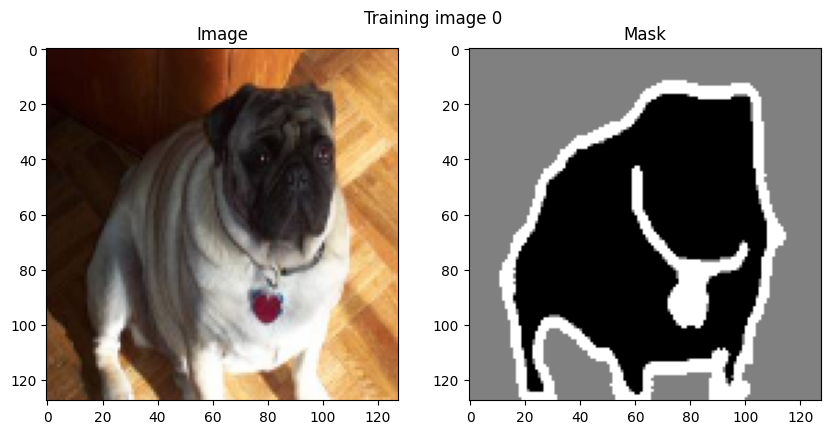

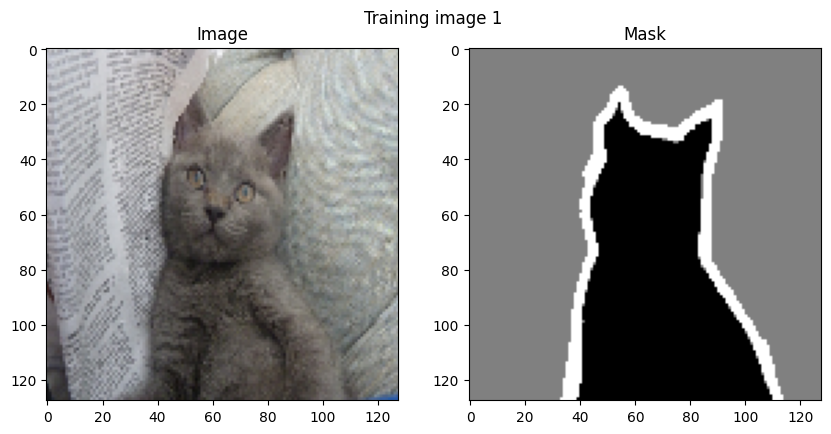

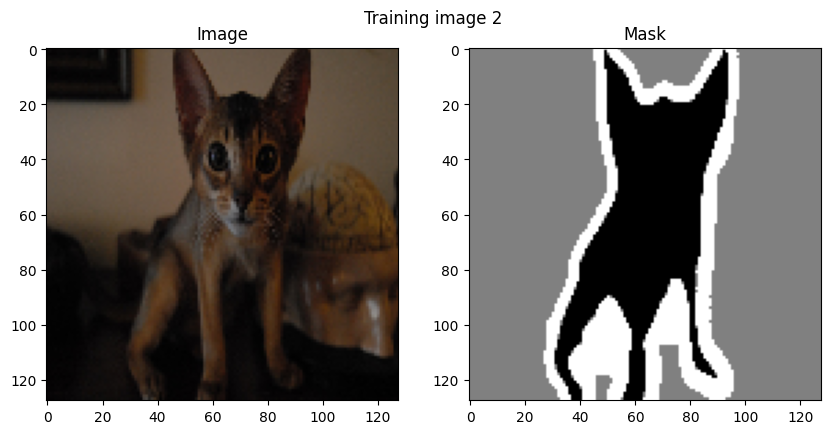

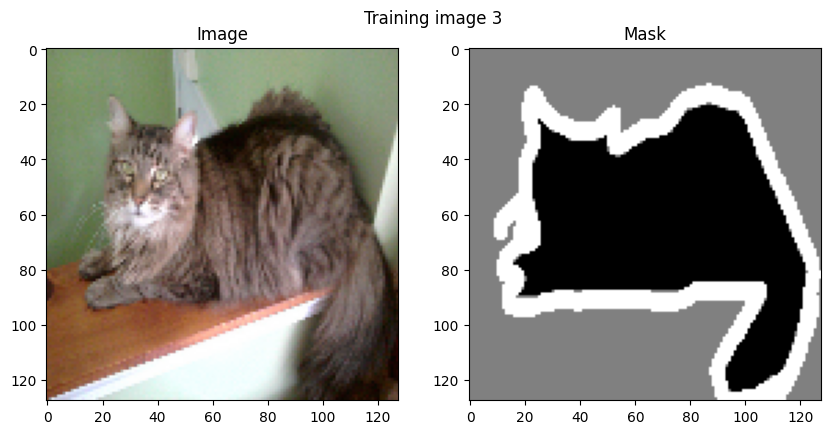

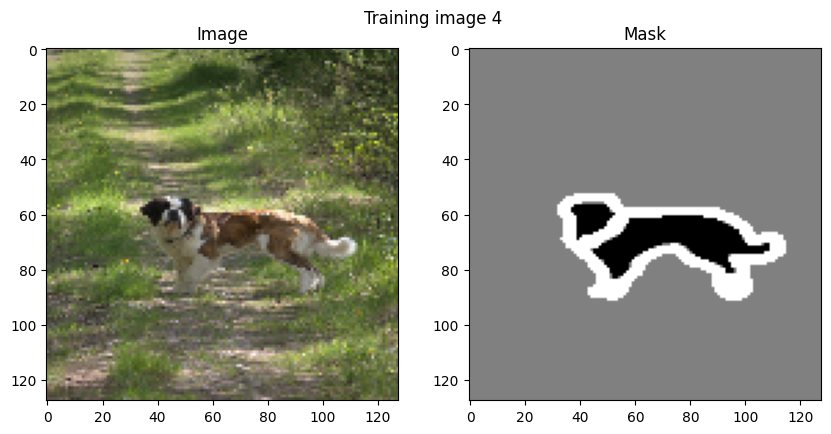

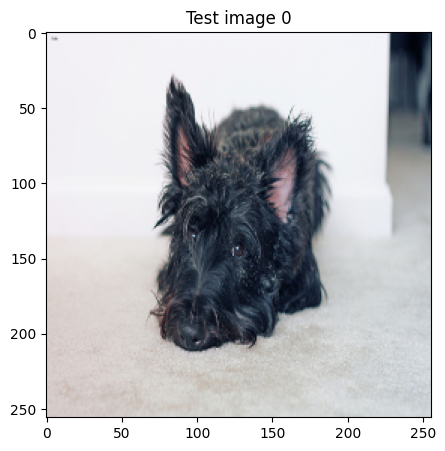

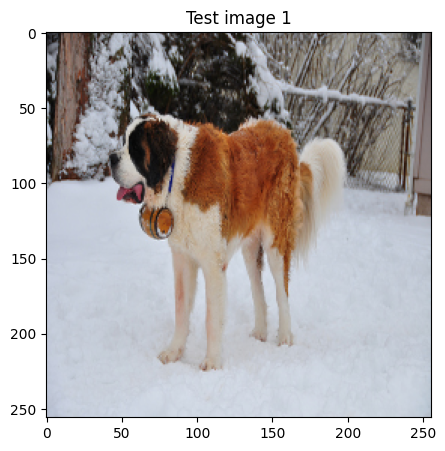

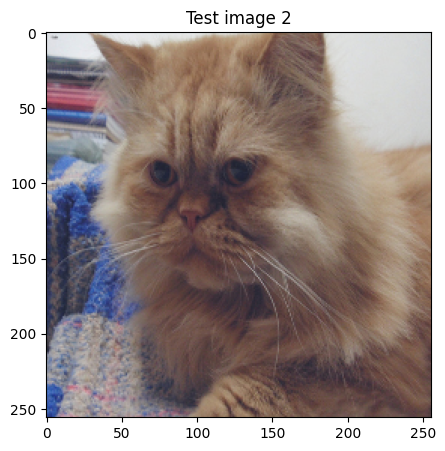

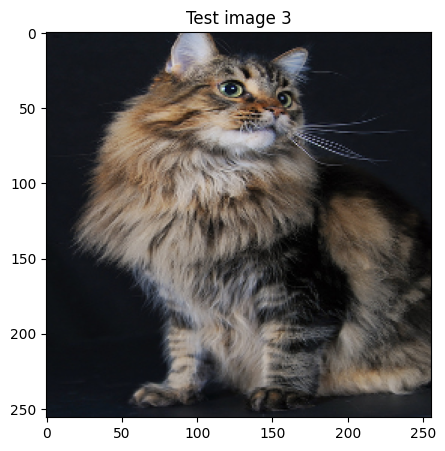

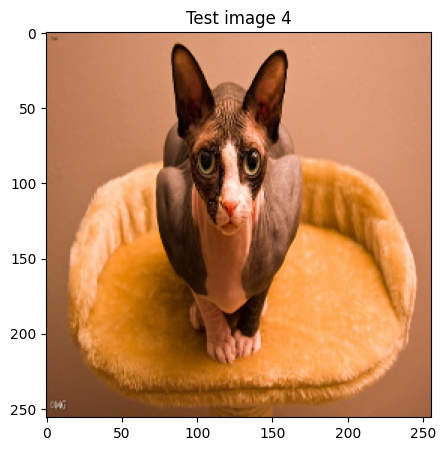

In [4]:
# Helper function to plot an image and its mask side by side
def plot_image_and_mask(image, mask, title):
    figure(figsize=(10, 5))
    plt.title(title)
    plt.axis('off')
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Image')
    if mask is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask')
    plt.show()

# Helper function to plot an image only (No mask)
def plot_image(image, title):
    figure(figsize=(5, 5))
    plt.title(title)
    plt.imshow(image)
    plt.show()

# Plot the first 5 training images and their mask
for i in range(5):
    plot_image_and_mask(X_train[i], y_train[i], f"Training image {i}")

# Plot the first 5 test images
for i in range(5):
    plot_image(X_test[i], f"Test image {i}")


# 2- Baseline methods

## 2.1- Traditional segmentation method: Gaussian mixture with k=3

We use Gaussian mixture models with k=3 to segment the images

In [5]:
# Create and fit the model (Inspired from the tutorial 8 notes)
gaussian_mixture = mixture.GaussianMixture(n_components=3, covariance_type='full')
gaussian_mixture.fit(X_train.reshape(-1, 3)) # Flattens the last dimension (RGB) to fit the model

GaussianMixture(n_components=3)

In [8]:
# Save the trained sklearn model using pickle
with open(f"{path_to_project_root}/gaussian_mixture_model.pkl", 'wb') as file:
    pickle.dump(gaussian_mixture, file)

## 2.2- Performance of the traditional model on the validation set

In [ ]:
#
# Dice score implementation from: https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py
#

def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

def multiclass_dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)

def calculate_accuracy(outputs, targets, convert_logits=True, reduce_batch_first=False):
   
    # Convert the logits to class predictions
    if convert_logits:
        outputs = torch.argmax(outputs, dim=1)

    # One-hot encode the outputs
    outputs = F.one_hot(outputs, num_classes=3).permute(0, 3, 1, 2)

    # One-hot encode the targets
    targets = F.one_hot(targets, num_classes=3).permute(0, 3, 1, 2)

    # Calculate the dice coefficient
    return multiclass_dice_coeff(outputs, targets, reduce_batch_first=reduce_batch_first).item()

In [ ]:
# Predict the labels for the validation set and reshape output
pred_labels_gaussian = gaussian_mixture.predict(X_val.reshape(-1, 3)).reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

# Convert the labels from 3, 2, 1 to 0, 1, 2
y_val_converted = y_val.copy()
y_val_converted[y_val == 3] = 2
y_val_converted[y_val == 2] = 1
y_val_converted[y_val == 1] = 0

# Calculate the dice score for the Gaussian Mixture Model
dice_score_gaussian = calculate_accuracy(torch.LongTensor(pred_labels_gaussian), torch.LongTensor(y_val_converted), convert_logits=False, reduce_batch_first=False)

# Print the dice score
print(f"Dice score for the Gaussian Mixture Model: {dice_score_gaussian}")

Dice score for the Gaussian Mixture Model: 0.2708449959754944


## 2.3- Visualizing outputs on the validation set along with the ground truth

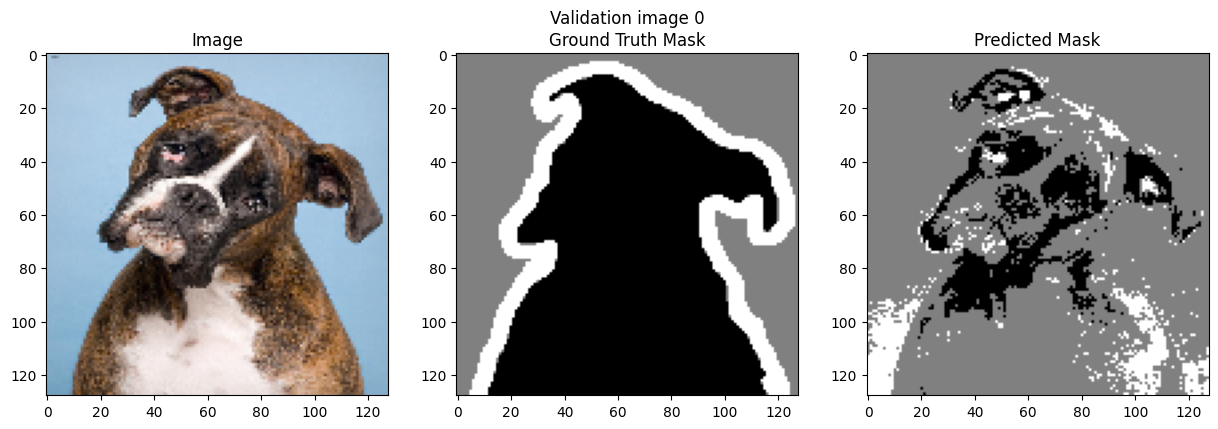

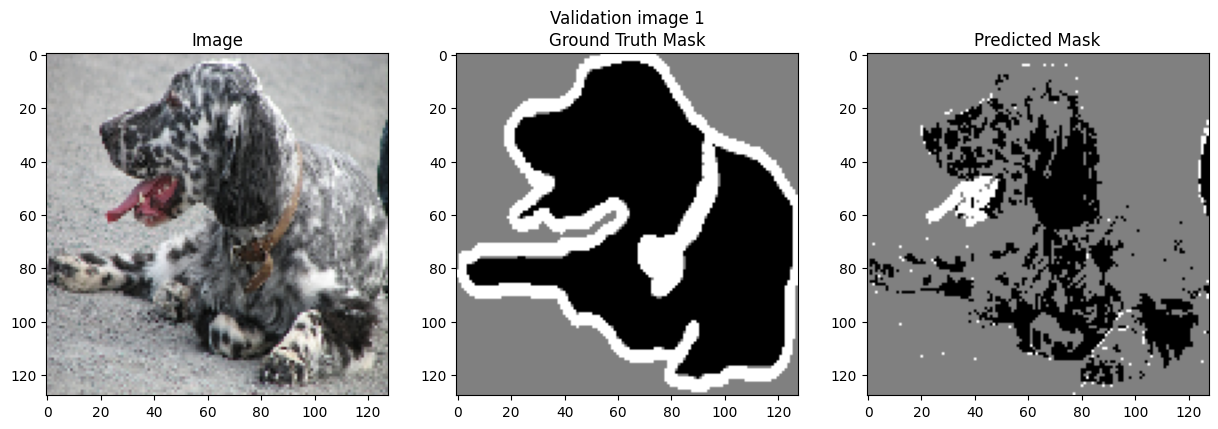

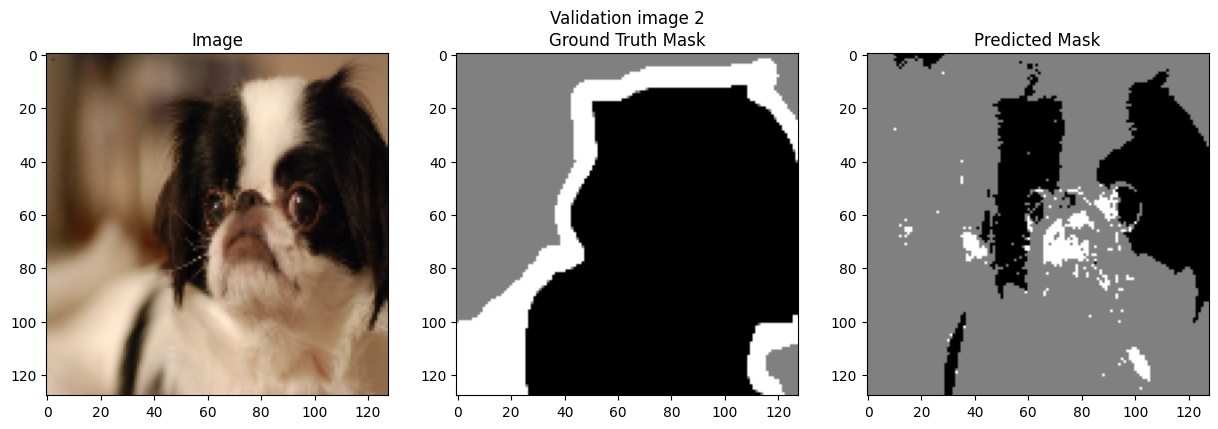

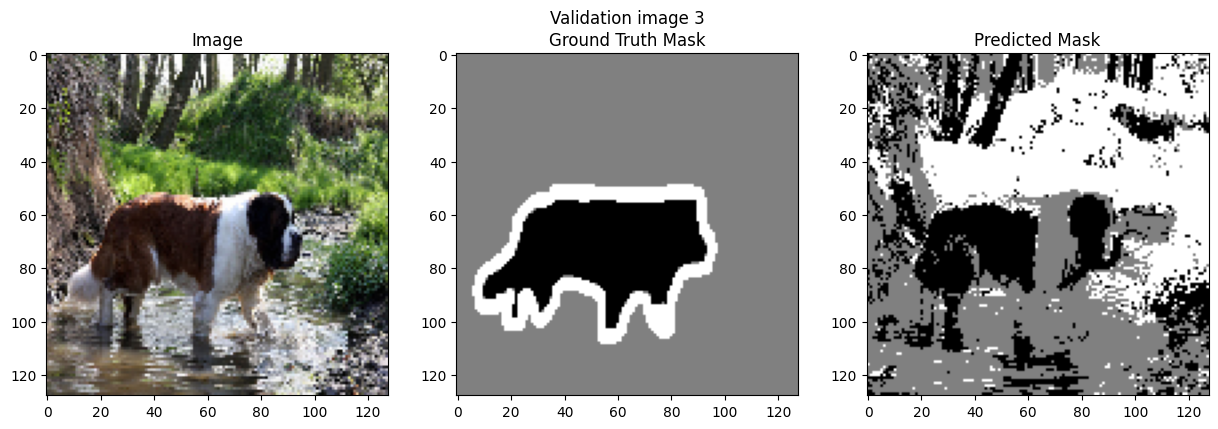

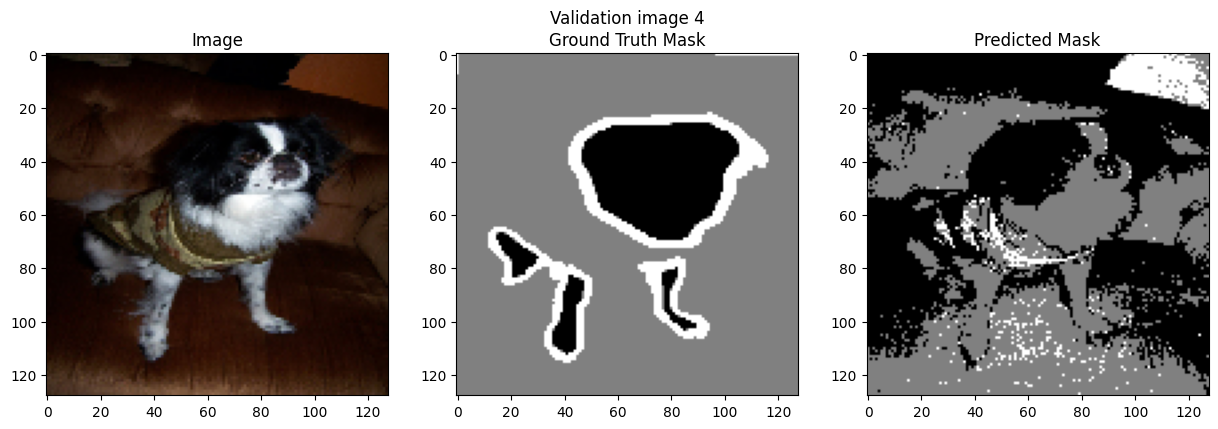

In [12]:
# Helper function to plot an image, its predicted mask, and the ground truth side by side
def plot_image_mask_pred(image, mask, pred, title):
    figure(figsize=(15, 5))
    plt.title(title)
    plt.axis('off')
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f'Image')
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Ground Truth Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='gray')
    plt.title(f'Predicted Mask')
    plt.show()

# Plot the first 5 validation images, their mask, and the predicted mask
for i in range(5):
    plot_image_mask_pred(X_val[i], y_val[i], pred_labels_gaussian[i], f"Validation image {i}")

# 3- Model implementation

## 3.1- Implementing UNet (https://arxiv.org/abs/1505.04597)

We load a pre-trained UNet baseline trained for brain segmentation (https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/), with the following architecture:1

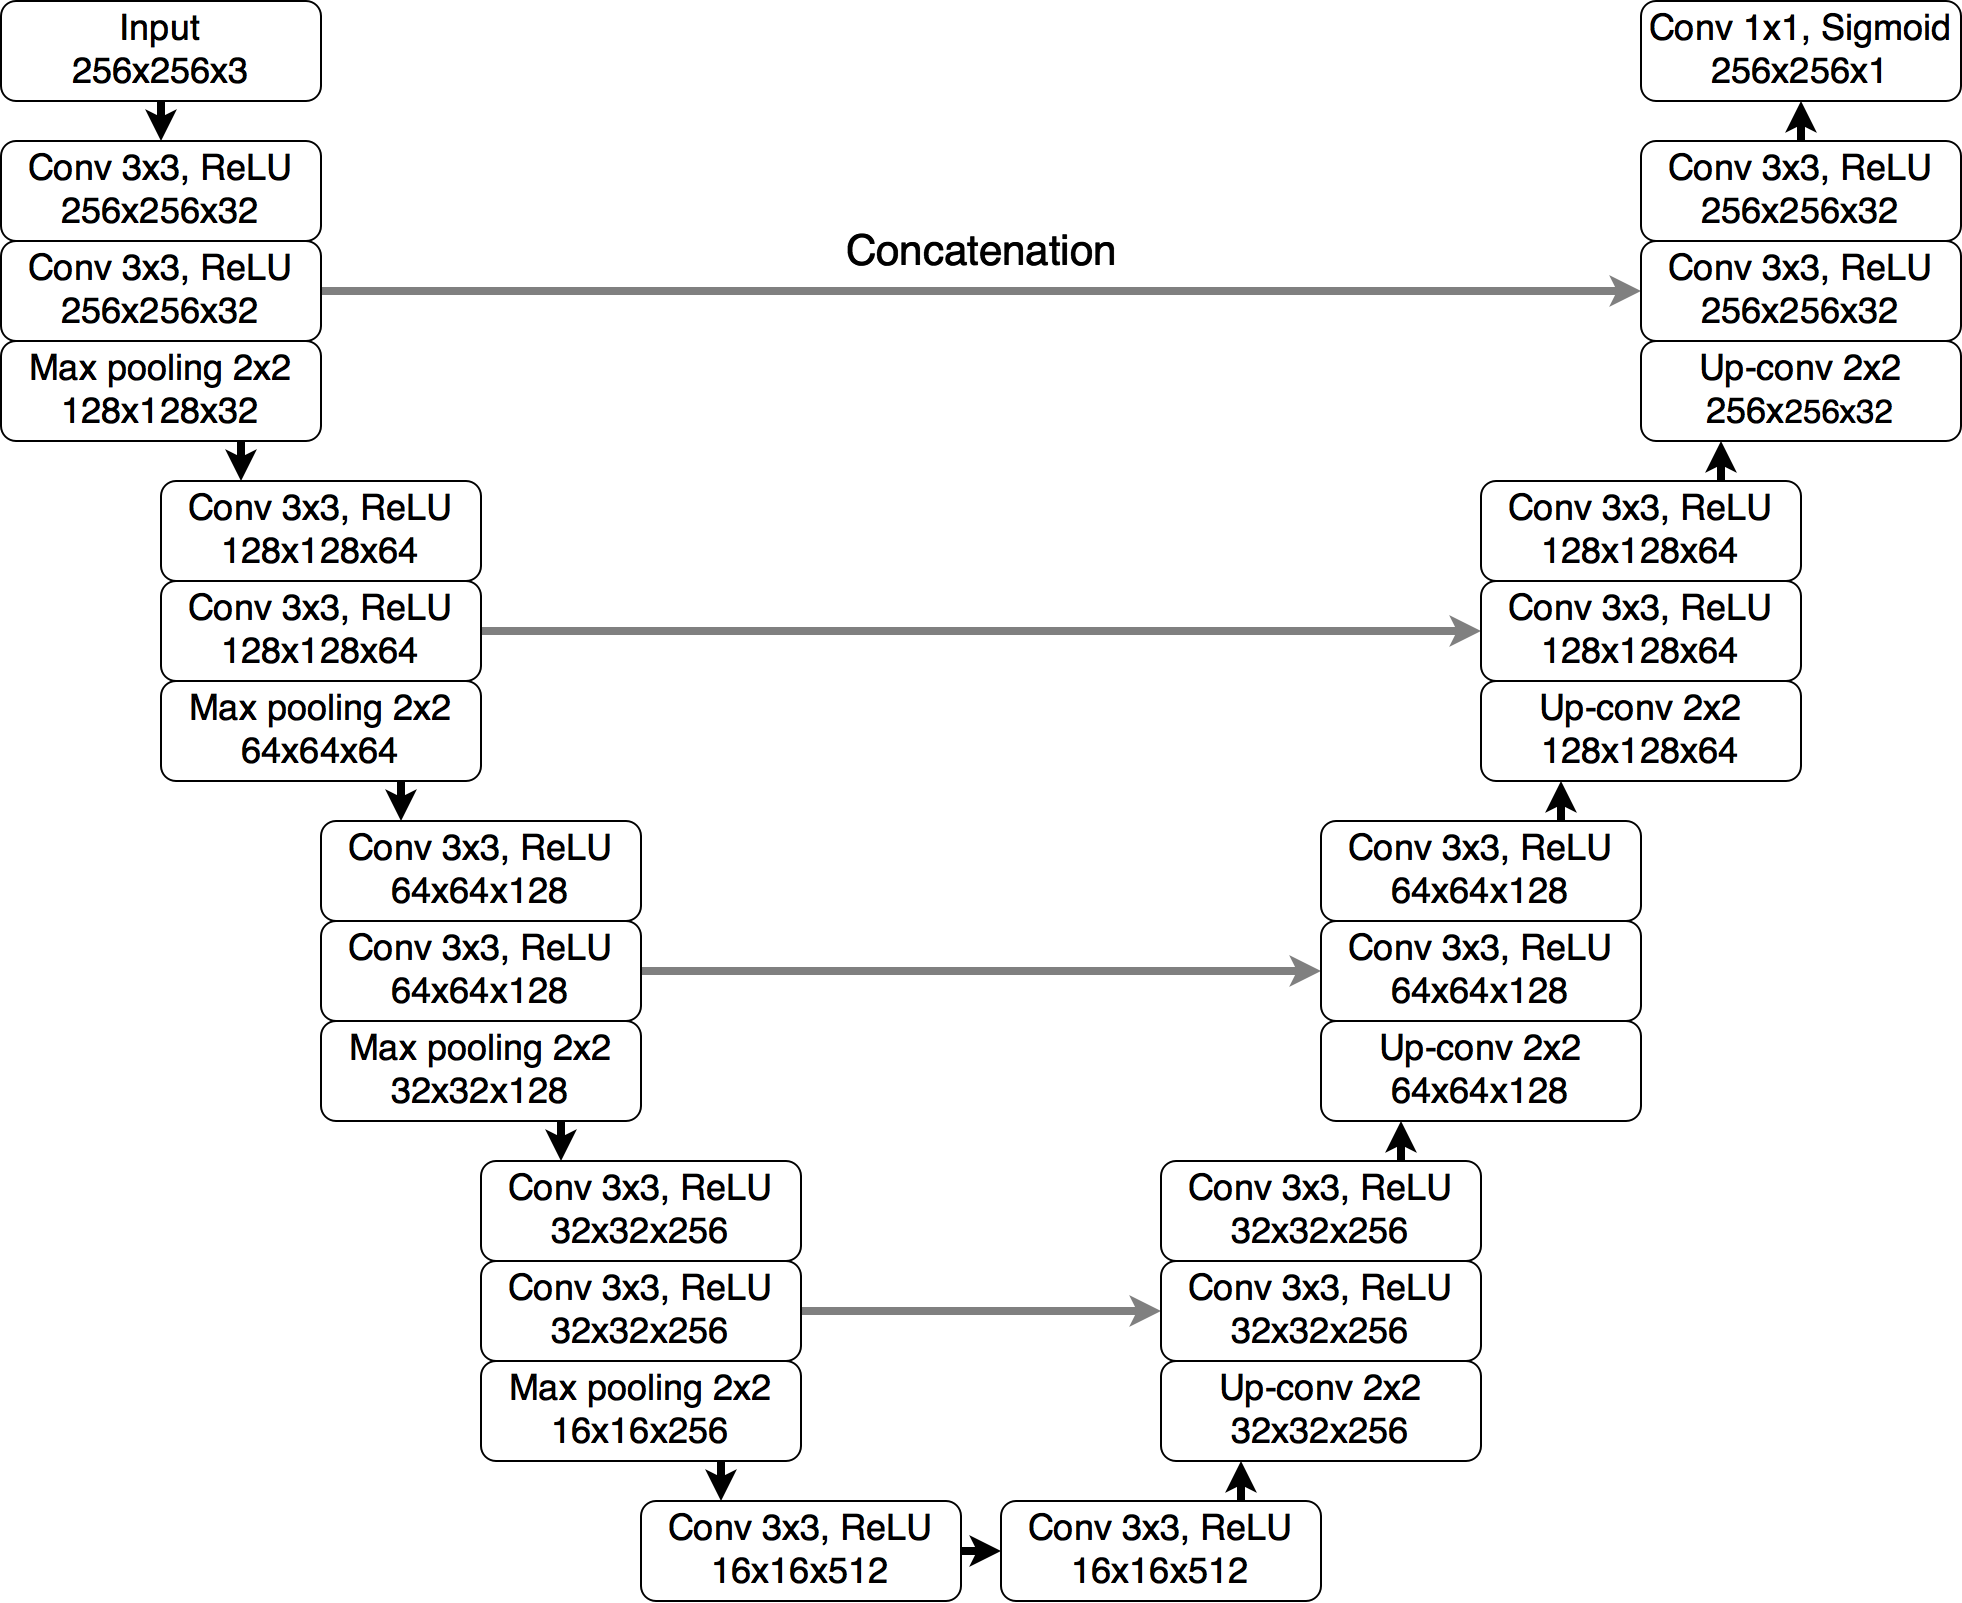

In [239]:
# Function to create a new UNet model
def create_unet_model():
    # Define the UNet model
    unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)
    # Replace the last classification layer with 3 output channels instead of one (Since we have 3 classes)
    unet.conv = nn.Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
    # Return the created model
    return unet

In [240]:
print(create_unet_model())

Using cache found in C:\Users\wassi/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## 3.2- Data augmentation

We start by creating a transform to augment the data, as well as a custom dataset class and dataloader.

In [288]:
# Apply data augmentations (Flips, Rotations, Crops)
aug_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0), ratio=(1.0, 1.0), interpolation=InterpolationMode.NEAREST)
])

# Transform to just convert to Pytorch tensor without data augmentation
torch_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create a custom dataset object to return the data (Incorporated in the dataloader later)
class ImageMaskDataset(Dataset):
    def __init__(self, images, masks=None, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    # Used to reset the seed every time a new transform is applied to an image and its mask (To get the same rotation/cropping on both)
    def _set_seed(self, seed):
        random.seed(seed)
        torch.manual_seed(seed)

    def __getitem__(self, idx):

        # Extract the image
        image = self.images[idx]

        # Apply the SAME transform (Seeding) to both the image and the mask
        if self.masks is not None:
            mask = self.masks[idx]
            seed = random.randint(0, 2**32)
            self._set_seed(seed)
            transformed_image = self.transform(np.copy(image))
            self._set_seed(seed)
            transformed_mask = self.transform(np.copy(mask))

            # Important: Replace any zeros in the mask with twos 
            # Explanation: After rotation, we sometimes get zeros in empty areas, those should be OUTSIDE the pet (Hence label 2)
            transformed_mask[transformed_mask == 0] = 2
            
            # Now we can convert the mask from labels 1, 2, and 3 to 0, 1, and 2
            transformed_mask -= 1
            
            return transformed_image.type(torch.FloatTensor), transformed_mask.type(torch.LongTensor)
        
        # Otherwise apply to transform to the image only
        else:
            transformed_image = self.transform(np.copy(image))
            return transformed_image.type(torch.FloatTensor)

# Create datasets for the train/val tasks
train_dataset = ImageMaskDataset(X_train, y_train, transform=aug_transform)
val_dataset = ImageMaskDataset(X_val, y_val, transform=torch_transform) # No transforms for validation
test_dataset = ImageMaskDataset(X_test, transform=torch_transform)

# Create dataloaders for train/val/test (Fix the batch size to 32)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=False)

c:\Users\wassi\Desktop\Courses\McGill Courses\5th year (Fall2024)\ECSE415\Assignments\Assignment 4\env\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


We can test that the transforms and dataloaders are working by visualizing a few examples for each of them:

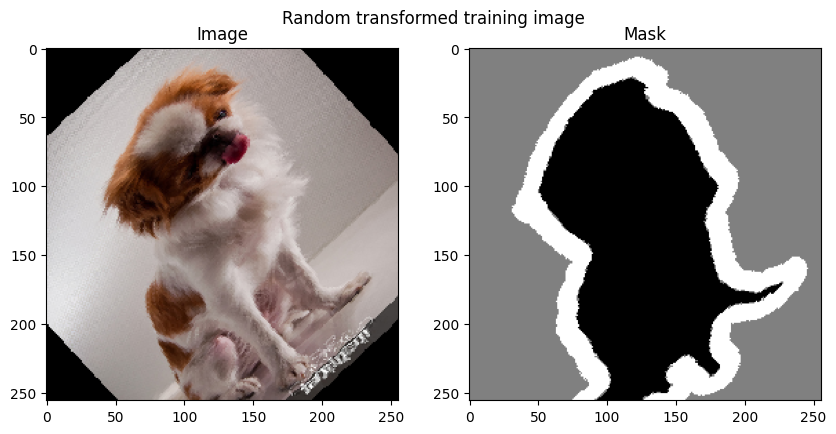

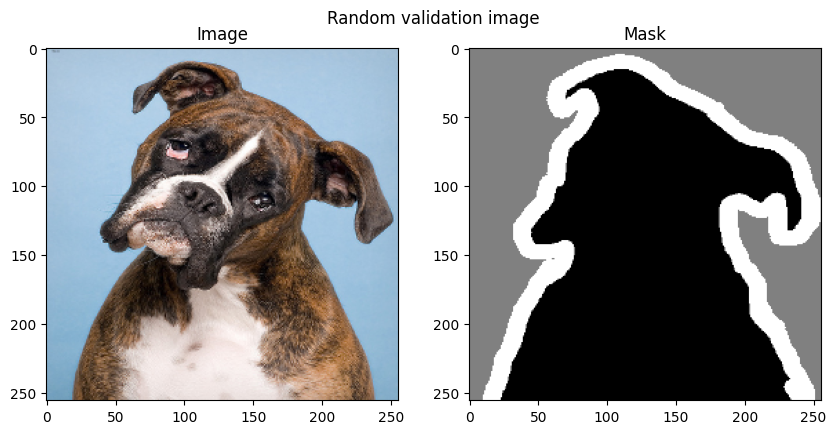

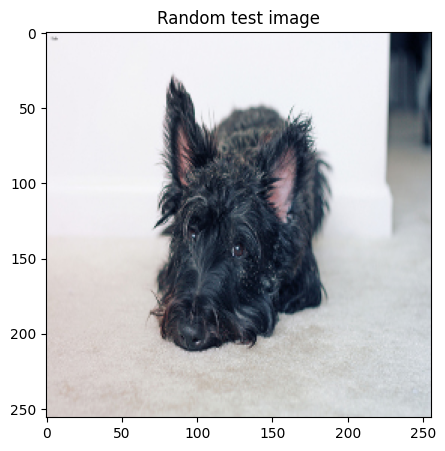

In [242]:
for (X_batch_train, y_batch_train) in train_loader:
    plot_image_and_mask(X_batch_train[0].permute(1, 2, 0), y_batch_train[0].permute(1, 2, 0), "Random transformed training image")
    break
for (X_batch_val, y_batch_val) in val_loader:
    plot_image_and_mask(X_batch_val[0].permute(1, 2, 0), y_batch_val[0].permute(1, 2, 0), "Random validation image")
    break
for X_batch_test in test_loader:
    plot_image(X_batch_test[0].permute(1, 2, 0), "Random test image")
    break

## 3.3- Train the model

We start by setting up the code for GPU training and writing a function that runs the training process given the learning rate and number of epochs:

In [ ]:
# Check if GPU is available to speed up training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

#
# Training function
#

# Write the training loop with an argument n_steps_before_validation
# The loss function can be 'dice_loss' or 'cross_entropy'
def train_model(model, train_loader, val_loader, lr=0.001, n_epochs=50):

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # ADAM optimizer with learning rate lr

    # Move the model to the device (For GPU training)
    model.to(device)

    # Initialize the tracking arrays
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Best validation accuracy
    best_val_acc = 0.0

    # Calculate the initial training and validation loss and accuracy
    with torch.no_grad():
            
        # Initialize the running metrics
        running_train_loss = 0.0
        running_train_acc = 0.0

        # Set the model to evaluation mode
        model.eval()

        # Loop through the training data
        for X_train_batch, y_train_batch in tqdm(train_loader, "Initial Training Eval"):

            # Move the data to the device
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

            # Forward pass
            outputs = model(X_train_batch)

            # Calculate the loss
            loss = criterion(torch.squeeze(outputs), torch.squeeze(y_train_batch))
        
            # Add the loss to the running loss
            running_train_loss += loss.item()

            # Calculate and add the accuracy to the running accuracy
            running_train_acc += calculate_accuracy(torch.squeeze(outputs), torch.squeeze(y_train_batch))
        
        # Calculate the average training loss
        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Calculate the average training accuracy
        train_acc = running_train_acc / len(train_loader)
        train_accs.append(train_acc)

        # Initialize the running metrics
        running_val_loss = 0.0
        running_val_acc = 0.0

        # Loop through the validation data
        for X_val_batch, y_val_batch in tqdm(val_loader, "Initial Validation Eval"):
                
            # Move the data to the device
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            # Forward pass
            outputs = model(X_val_batch)

            # Calculate the loss
            loss = criterion(torch.squeeze(outputs), torch.squeeze(y_val_batch))

            # Add the loss to the running loss
            running_val_loss += loss.item()

            # Add the accuracy to the running accuracy
            running_val_acc += calculate_accuracy(torch.squeeze(outputs), torch.squeeze(y_val_batch))

        # Calculate the average validation loss
        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

        # Calculate the average validation accuracy
        val_acc = running_val_acc / len(val_loader)
        val_accs.append(val_acc)
    
    # Print the initial training and validation loss and accuracy
    print(f"Initially => Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Loop through the epochs
    for epoch in range(n_epochs):

        # Initialize the running metrics
        running_train_loss = 0.0
        running_train_acc = 0.0

        # Set the model to training mode
        model.train()

        # Loop through the training data
        for X_train_batch, y_train_batch in tqdm(train_loader, f"Epoch {epoch + 1}/{n_epochs}"):

            # Move the data to the device
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_train_batch)

            # Calculate the loss
            loss = criterion(torch.squeeze(outputs), torch.squeeze(y_train_batch))

            # Backward pass
            loss.backward()

            # Optimize
            optimizer.step()

            # Add the loss to the running loss
            running_train_loss += loss.item()

            # Add the accuracy to the running accuracy
            running_train_acc += calculate_accuracy(torch.squeeze(outputs), torch.squeeze(y_train_batch))
        
        # Calculate the average training loss
        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Calculate the average training accuracy
        train_acc = running_train_acc / len(train_loader)
        train_accs.append(train_acc)

        # Iterate through the validation data with gradient calculations
        with torch.no_grad():

            # Initialize the running metrics
            running_val_loss = 0.0
            running_val_acc = 0.0

            # Set the model to evaluation mode
            model.eval()

            # Loop through the validation data
            for X_val_batch, y_val_batch in tqdm(val_loader, f"Epoch {epoch + 1}/{n_epochs} Validation"):

                # Move the data to the device
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                # Forward pass
                outputs = model(X_val_batch)

                # Calculate the loss
                loss = criterion(torch.squeeze(outputs), torch.squeeze(y_val_batch))

                # Add the loss to the running loss
                running_val_loss += loss.item()
                
                # Add the accuracy to the running accuracy
                running_val_acc += calculate_accuracy(torch.squeeze(outputs), torch.squeeze(y_val_batch))

            # Calculate the average validation loss
            val_loss = running_val_loss / len(val_loader)
            val_losses.append(val_loss)

            # Calculate the average validation accuracy
            val_acc = running_val_acc / len(val_loader)
            val_accs.append(val_acc)

            # If the validation accuracy is the best so far, save the model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f"{path_to_project_root}/best_model_lr_{lr}.pth")
                print(f"Best model saved with validation accuracy: {best_val_acc:.4f}")
        
        # Print the epoch number, training loss, validation loss, training accuracy, and validation accuracy
        print(f"Epoch {epoch + 1}/{n_epochs} => Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

Using device: cuda


We now call the function above to train the model using the cross entropy loss first, using a learning rate of 0.001 and 10 epochs:

In [ ]:
lr_choices = [0.001, 0.005]
stored_results = {}

# Train the model with different learning rates
for lr in lr_choices:

    # Load the model
    unet = create_unet_model()

    # Print the learning rate
    print(f"------------------------------------------------------------------------------------------------------")
    print(f"Learning rate: {lr}")
    train_losses, val_losses, train_accs, val_accs = train_model(unet, train_loader, val_loader, lr=lr, n_epochs=100)
    stored_results[lr] = (train_losses, val_losses, train_accs, val_accs)
    print(f"------------------------------------------------------------------------------------------------------")

# Save the resulting dictionary
torch.save(stored_results, f"{path_to_project_root}/all_metrics.pth")

We can now load the saved file above and find the best model:

In [311]:
# Load the saved results
results = torch.load(f"{path_to_project_root}/all_metrics.pth", weights_only=True)

# Find the learning rate with the best validation accuracy peak
best_lr = None
best_val_acc = 0.0
best_epoch = 0
for lr in results.keys():
    val_accs = results[lr][3]
    if max(val_accs) > best_val_acc:
        best_val_acc = max(val_accs)
        best_lr = lr
        best_epoch = val_accs.index(max(val_accs)) + 1


# Print the best learning rate and the epoch at which it occurred
print(f"Best learning rate: {best_lr}")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Best epoch: {best_epoch}")

Best learning rate: 0.001
Best validation accuracy: 0.8504
Best epoch: 89


We can also first plot all the accuracy and loss curves for each of the models:

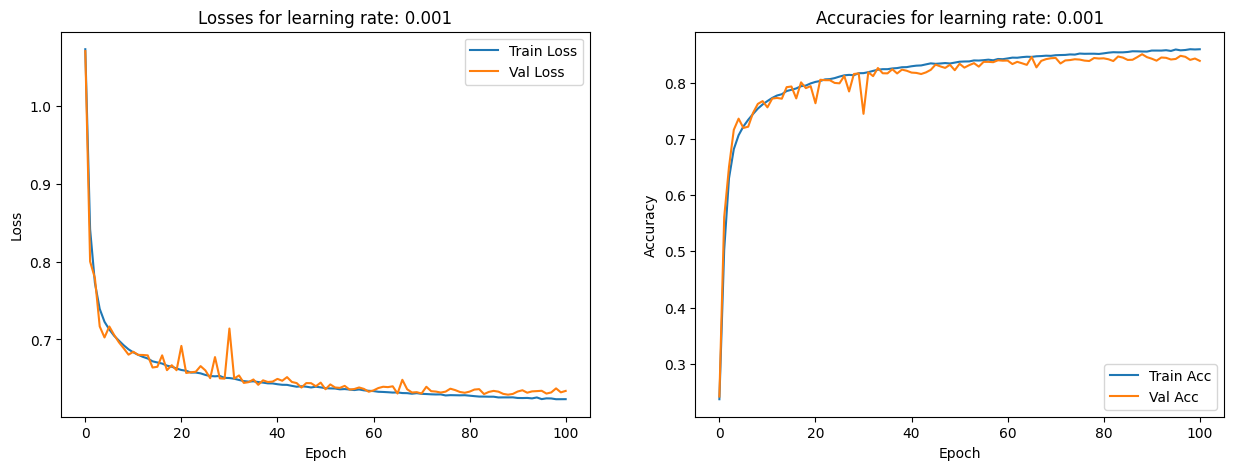

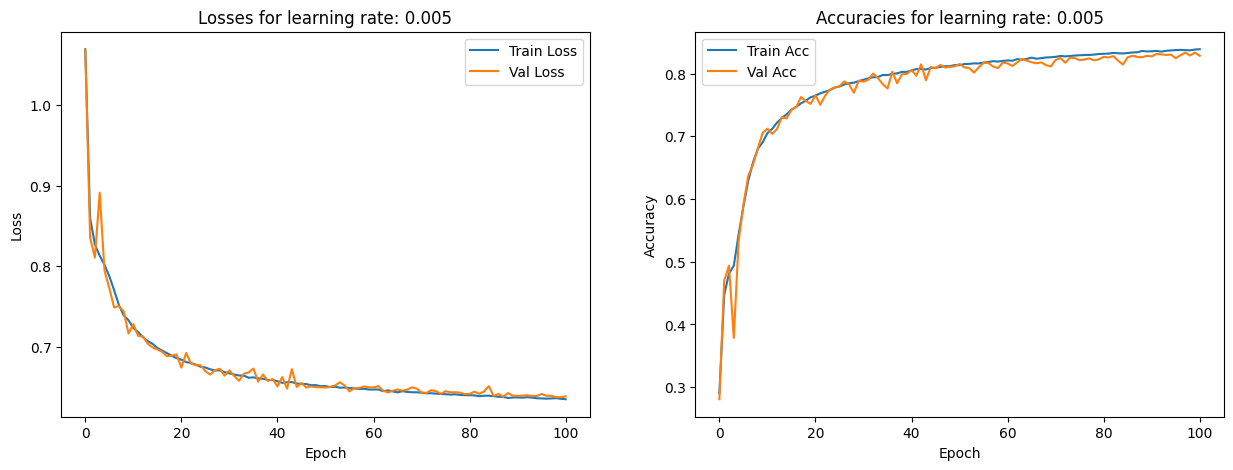

In [312]:
# Iterate over the learning rates
for lr in results.keys():

    # Extract the results
    train_losses, val_losses, train_accs, val_accs = results[lr]

    # Make 2 subplots, one for the loss and one for the accuracy
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the losses
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')

    # Set the title and labels
    axs[0].set_title(f'Losses for learning rate: {lr}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot the accuracies
    axs[1].plot(train_accs, label='Train Acc')
    axs[1].plot(val_accs, label='Val Acc')

    # Set the title and labels
    axs[1].set_title(f'Accuracies for learning rate: {lr}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

# 4- Model evaluation

## 4.1- Performance on the validation set

In [316]:
# Load the best model
best_model = create_unet_model()
best_model.load_state_dict(torch.load(f"{path_to_project_root}/best_model_lr_{best_lr}.pth"), weights_only=True)

# Move the model to the device
best_model.to(device)

# Set the model to evaluation mode
best_model.eval()

# Recalculate the accuracy on the validation set to ensure things add up
with torch.no_grad():

    # Seed the random number generator
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    # Initialize the running metrics
    running_val_acc = 0.0

    # Loop through the validation data
    for X_val_batch, y_val_batch in tqdm(val_loader, "Validation Eval"):

        # Move the data to the device
        X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

        # Forward pass
        outputs = best_model(X_val_batch)

        # Add the accuracy to the running accuracy
        running_val_acc += calculate_accuracy(outputs.squeeze(), y_val_batch.squeeze())

    # Calculate the average validation accuracy
    val_acc = running_val_acc / len(val_loader)

    # Print the validation loss and accuracy
    print(f"Final Validation Accuracy: {val_acc:.4f}")


Using cache found in C:\Users\wassi/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
C:\Users\wassi\AppData\Local\Temp\ipykernel_10020\548058457.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues re

Final Validation Accuracy: 0.8504


## 4.2- Visualizing outputs on the validation set along with the ground truth

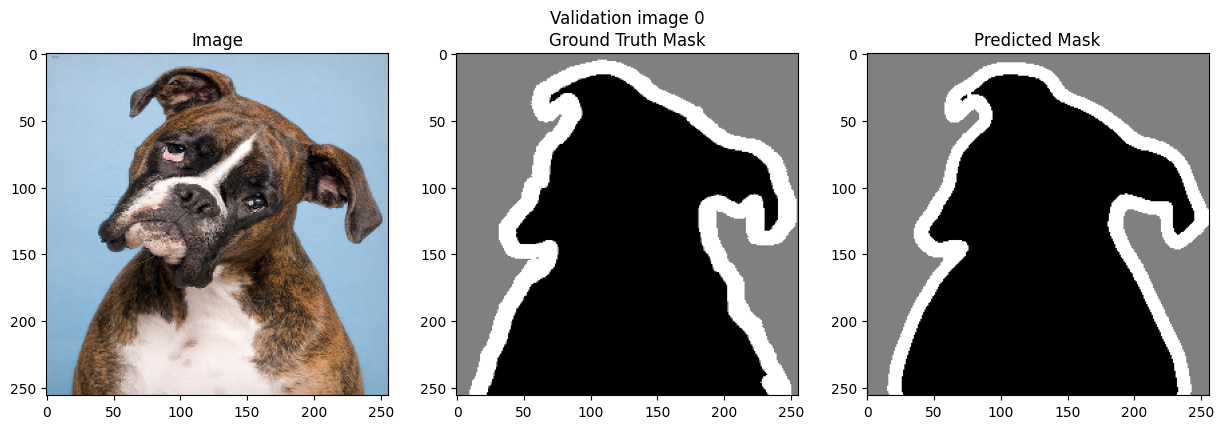

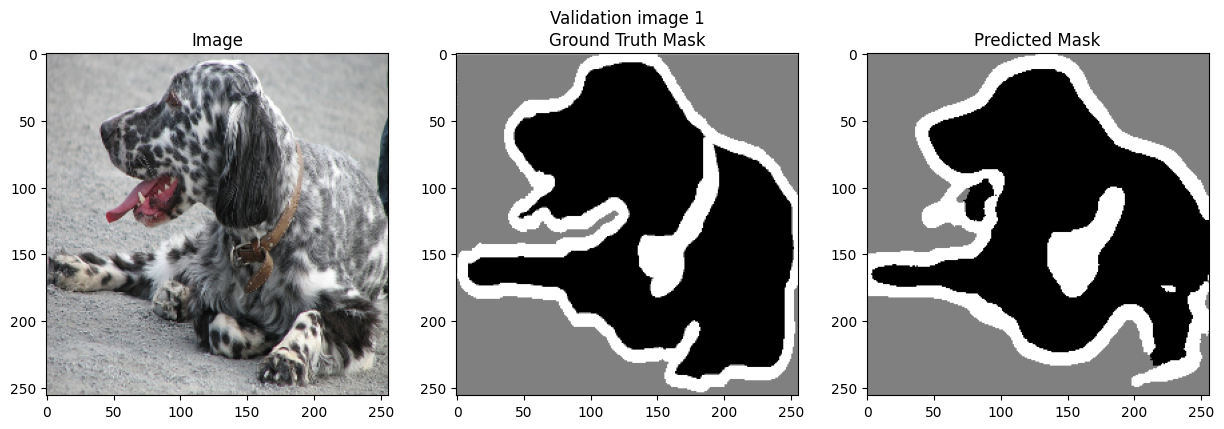

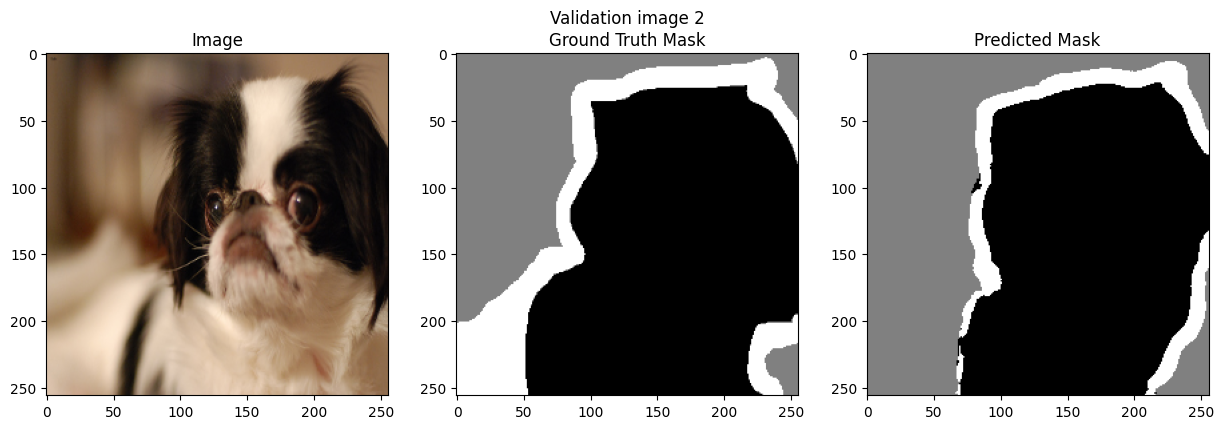

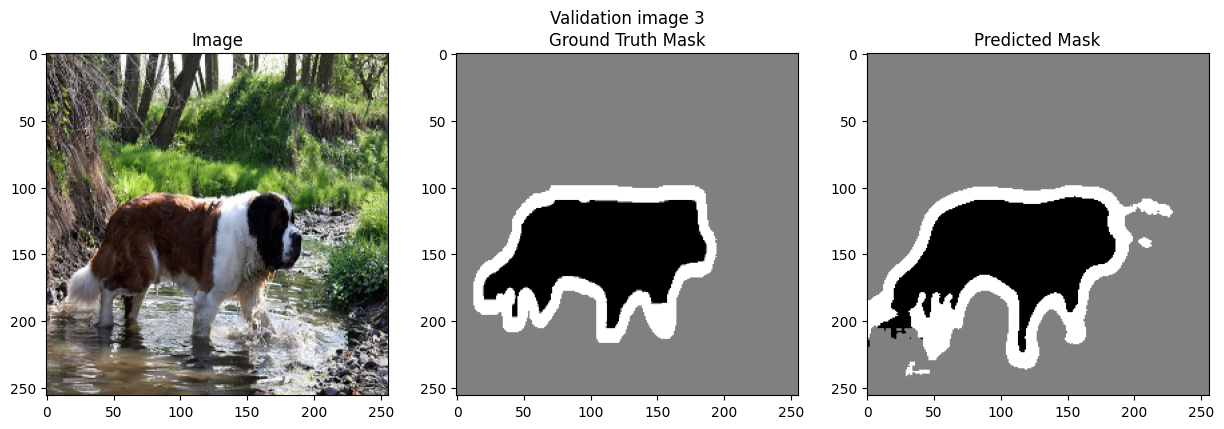

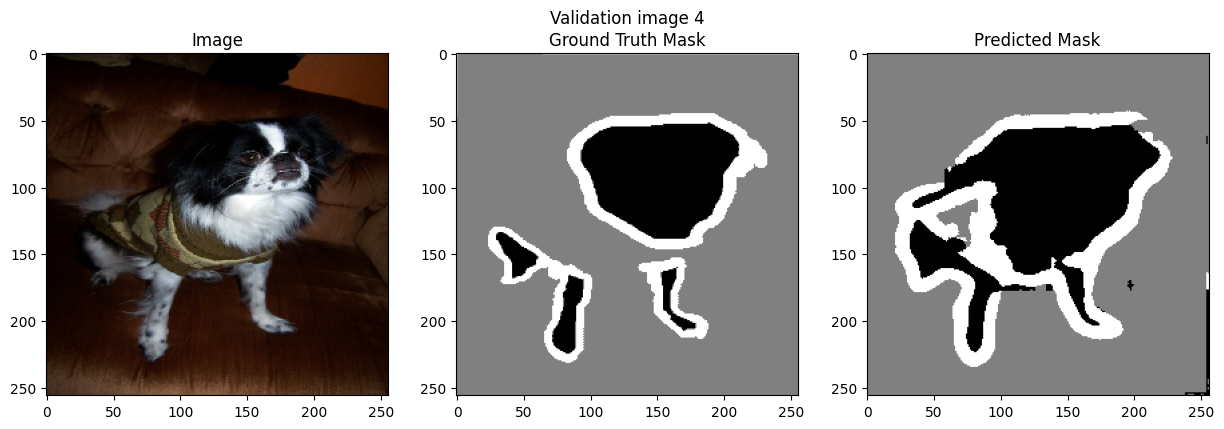

In [318]:
# Visualize 5 images from the validation set with their ground truth masks and predicted masks
for X_val_batch, y_val_batch in val_loader:

    # Move the data to the device
    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

    # Forward pass
    outputs = best_model(X_val_batch)

    # Find the outputs with the highest probabilities
    outputs = torch.argmax(outputs, dim=1)

    # Convert the outputs to a numpy array
    outputs = outputs.squeeze().cpu().detach().numpy()

    # Iterate through the batch
    for i in range(5):

        # Convert the image and ground truth to a numpy array
        cur_img = X_val_batch[i].permute(1, 2, 0).cpu().numpy()
        cur_ground_truth = y_val_batch[i].squeeze().cpu().numpy()

        # Plot the image, the ground truth mask, and the predicted mask
        plot_image_mask_pred(cur_img, cur_ground_truth, outputs[i], f"Validation image {i}")

    break

## 4.3- Generalization test

We use the image of a dog from this website for the generalization test: https://www.vera-lynn.be/en/pages/voor-de-honden

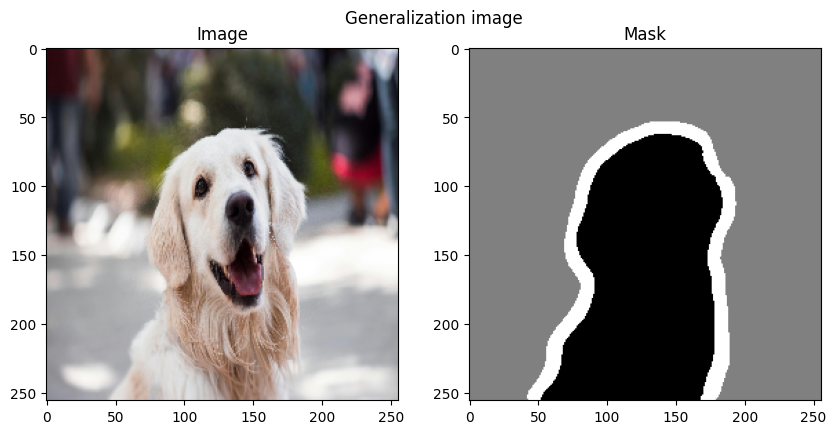

In [319]:
# Load the generalization image
generalization_img = cv2.imread(generalization_image_path)
generalization_img = cv2.cvtColor(generalization_img, cv2.COLOR_BGR2RGB) # Convert to RGB
generalization_img = generalization_img / 255.0 # Normalize the image
generalization_img = cv2.resize(generalization_img, (256, 256)) # Resize the image

# Convert the image to a tensor
generalization_img_tensor = torch.Tensor(generalization_img).permute(2, 0, 1).unsqueeze(0)

# Move the data to the device
generalization_img_tensor = generalization_img_tensor.to(device)

# Forward pass
generalization_output = best_model(generalization_img_tensor)

# Find the outputs with the highest probabilities
generalization_output = torch.argmax(generalization_output, dim=1)

# Convert the outputs to a numpy array
generalization_output = generalization_output.squeeze().cpu().detach().numpy()

# Plot the generalization image and the predicted mask
plot_image_and_mask(generalization_img, generalization_output, "Generalization image")

# 5- Prediction & Kaggle competition

In [ ]:
# Generate test predictions
with torch.no_grad():

    # Set the model in eval mode
    best_model.eval()

    # Iterate through the test data
    for i, X_test_batch in enumerate(tqdm(test_loader, "Test Eval")):

        # Move the data to the device
        X_test_batch = X_test_batch.to(device)

        # Forward pass
        outputs = best_model(X_test_batch)

        # Find the outputs with the highest probabilities
        outputs = torch.argmax(outputs, dim=1)

        # Convert the outputs to a numpy array
        outputs = outputs.squeeze().cpu().detach().numpy()

        # Add 1 to the outputs to convert the labels from 0, 1, 2 to 1, 2, 3
        outputs += 1

        # Iterate through the batch
        for j in range(outputs.shape[0]):

            # Find the original image size by loading the image
            img = cv2.imread(os.path.join(test_set_images_path, f"{i * 8 + j + 1}.jpg"))

            # Resize the output to the original image size
            if img is not None:
                pred_mask = cv2.resize(outputs[j], (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
            else:
                print(f"Image {i * 8 + j + 1} not found; Replacing with a black image")
                pred_mask = np.zeros((256, 256))

            # Save the mask
            cv2.imwrite(f"{path_to_project_root}/Oxford/test/pred_masks/{i * 8 + j + 1}.png", pred_mask)



Test Eval:  23%|██▎       | 58/250 [00:08<00:26,  7.15it/s]

Image 456 not found; Replacing with a black image


Test Eval:  34%|███▎      | 84/250 [00:12<00:23,  6.94it/s]

Image 667 not found; Replacing with a black image


Test Eval: 100%|██████████| 250/250 [00:38<00:00,  6.54it/s]
